In [1]:
import os                                         # To work with OS commands
import pandas as pd
from PIL import Image                             # To read Images
from termcolor import colored                     # To Colorfull output
from datetime import datetime                     # To calculate durations

import numpy as np                                # To work with Numpy arrays
import matplotlib.pyplot as plt                   # To Visualization
import seaborn as sns                             # To Visualization

import torch                                      # To work with TORCH framework
import torch.nn as nn                             # To work with Neural Networks
import torchvision                                # To work with image datasets
import torchvision.transforms as transforms       # To create data transforms
from torch.utils.data import Dataset, DataLoader,random_split

from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights # Pretrained model with its weights

from sklearn.metrics import confusion_matrix, classification_report # To Evaluate the result

In [2]:
train_path = '/kaggle/input/cassava-leaf-disease-classification/train.csv'
train_csv = pd.read_csv(train_path);
train_csv.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
base_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images'

In [4]:
transform = transforms.Compose(
    [        
        transforms.ToTensor(),                         # Convert images to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize R, G, B channels
    ]
)


In [5]:
image_path = '/kaggle/input/cassava-leaf-disease-classification/train_images/1005200906.jpg'

# Open the image file
with Image.open(image_path) as img:
    # Get the size of the image
    width, height = img.size
    print(f"Image size: {width} x {height}")

Image size: 800 x 600


In [6]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        # Set the directory where images are stored
        self.root_dir = root_dir
        # Apply any image transformations if provided
        self.transform = transform
    
    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the image name from the CSV file
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        # Open the image using PIL
        image = Image.open(img_name).convert('RGB')
        # Get the corresponding label from the CSV file
        label = self.data.iloc[idx, 1]
        
        # Apply any transformations to the image
        if self.transform:
            image = self.transform(image)
        
        # Return the image and its label
        return image, label

In [7]:
print(type(train_path))  # Should be <class 'str'>

<class 'str'>


In [8]:
print(train_path)       # Should be the file path as a string

/kaggle/input/cassava-leaf-disease-classification/train.csv


In [9]:
class CassavaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        # Set the directory where images are stored
        self.root_dir = root_dir
        # Apply any image transformations if provided
        self.transform = transform
    
    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the image name from the CSV file
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        # Open the image using PIL
        image = Image.open(img_name).convert('RGB')
        # Get the corresponding label from the CSV file
        label = self.data.iloc[idx, 1]
        
        # Apply any transformations to the image
        if self.transform:
            image = self.transform(image)
        
        # Return the image and its label
        return image, label

In [10]:
dataset = CassavaDataset(csv_file=train_path, root_dir=base_dir, transform=transform)

print("Images added with labels Now creating new dataset")




Images added with labels Now creating new dataset


### Lets divide into train and valid data

In [11]:
BATCH_SIZE=32
# Define the split ratio
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Dataloaders are done")

Dataloaders are done


In [12]:
image, label = dataset[3]
# image is the tensor form and label is the index no of the species
print(image.shape)
print(label)
image

torch.Size([3, 600, 800])
1


tensor([[[-0.5451, -0.5373, -0.5373,  ..., -0.7961, -0.7961, -0.7961],
         [-0.5294, -0.5294, -0.5216,  ..., -0.7882, -0.7804, -0.7725],
         [-0.5137, -0.5137, -0.5137,  ..., -0.7961, -0.7725, -0.7569],
         ...,
         [-0.3804, -0.3804, -0.3725,  ..., -0.4118, -0.3725, -0.4588],
         [-0.4118, -0.4118, -0.4118,  ..., -0.4980, -0.5216, -0.5765],
         [-0.4431, -0.4431, -0.4353,  ..., -0.6157, -0.6706, -0.6392]],

        [[ 0.0745,  0.0824,  0.0824,  ..., -0.2471, -0.2471, -0.2471],
         [ 0.0902,  0.0902,  0.0980,  ..., -0.2392, -0.2314, -0.2235],
         [ 0.0980,  0.0980,  0.1059,  ..., -0.2471, -0.2235, -0.2078],
         ...,
         [ 0.2314,  0.2392,  0.2392,  ..., -0.0510,  0.0039, -0.0824],
         [ 0.2000,  0.2000,  0.2000,  ..., -0.1059, -0.1294, -0.1843],
         [ 0.1686,  0.1686,  0.1765,  ..., -0.2157, -0.2627, -0.2314]],

        [[-0.2784, -0.2706, -0.2706,  ..., -0.7412, -0.7412, -0.7412],
         [-0.2627, -0.2627, -0.2549,  ..., -0

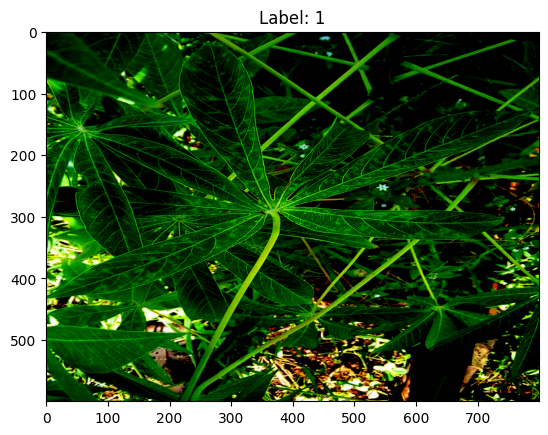

In [13]:
# To visualize the image, convert the tensor to a numpy array and plot it
image_np = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization

plt.imshow(image_np)
plt.title(f"Label: {label}")
plt.show()

In [14]:
import json

# Load the label to disease mapping
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 'r') as file:
    label_map = json.load(file)

# Print to check the contents
print(label_map)


{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


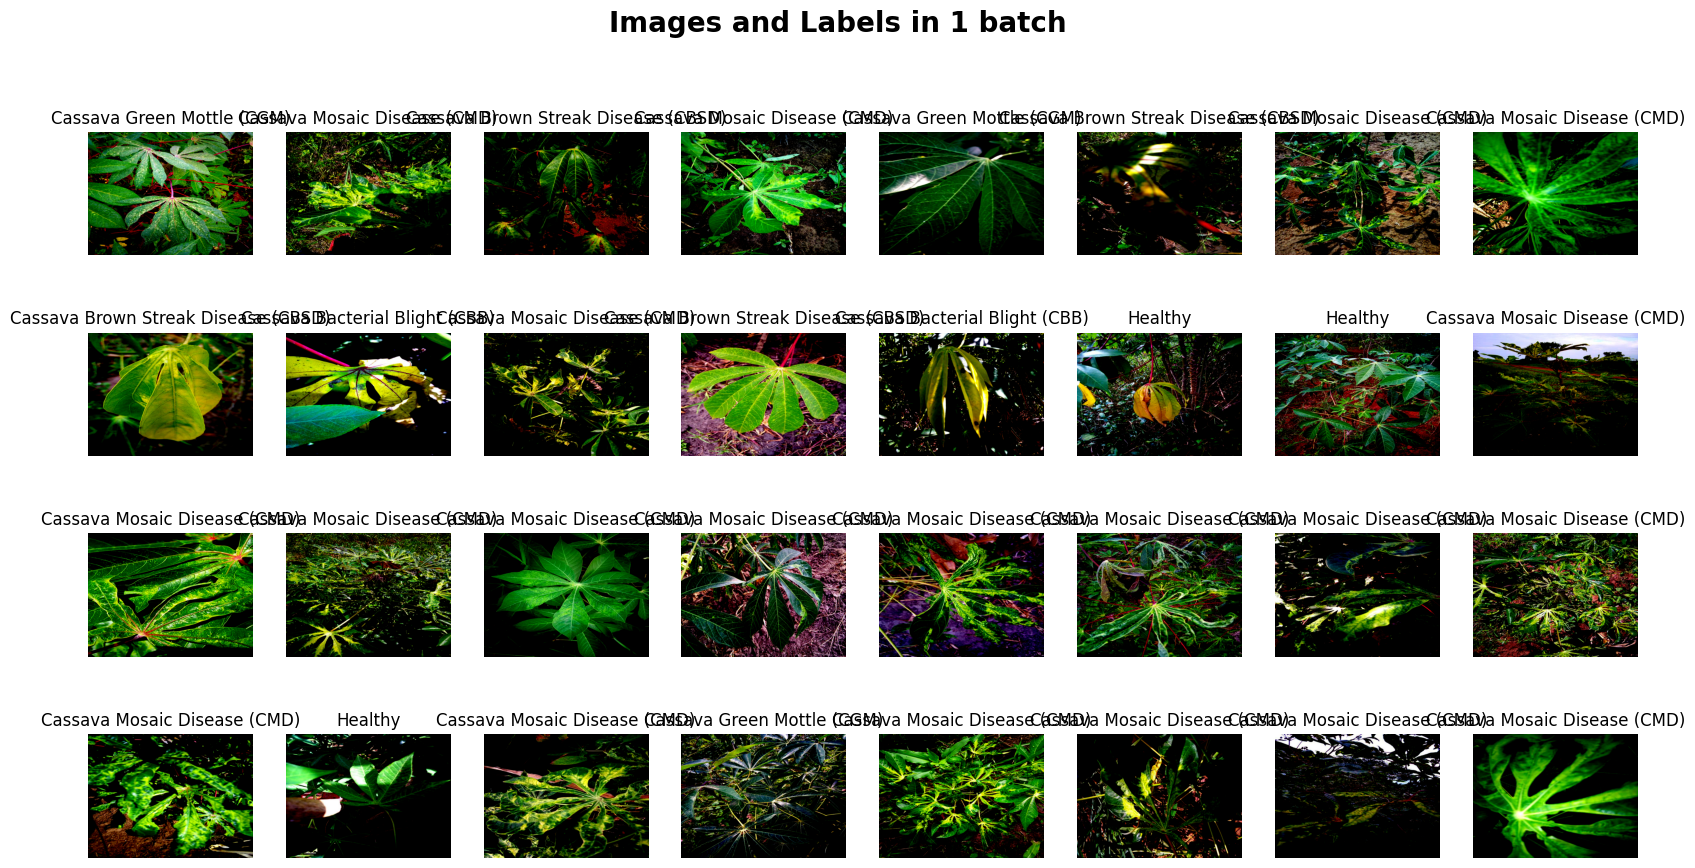

In [15]:
# lets 1st Fetch 1 Batch from train_loader(contain 32 Images and Labels)
for images, labels in train_loader :
    break
    
# Plot images and their labels in 1 batch (32 images and labels)
plt.subplots(4, 8, figsize=(20, 10))
plt.suptitle('Images and Labels in 1 batch', fontsize=20, fontweight='bold')

for i in range(BATCH_SIZE) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(images[i], (1, 2, 0))
    #Many visualization libraries, such as matplotlib expect images to be in the format [Height, Width, Channels]
    #But PyTorch’s default image tensor format is [Channels, Height, Width] (i.e., [C, H, W]),
    plt.imshow(img)
    plt.axis('off')
    # Convert label to class name using label_map
    label_name = label_map.get(str(labels[i].item()), 'Unknown')  # Ensure keys are strings
    plt.title(label_name)

plt.show()

## Using efficientnet_model.Then only uncomment these

In [16]:
# # Load efficientnet_b5 weight (best weight)
# weights = EfficientNet_B5_Weights.DEFAULT   # I have imported this..Check the beginning of this file

# # This function prepare images to feed into efficientnet_b5 model
# preprocess = weights.transforms()

# # Load efficientnet_b5 model with best weights
# efficientnet_model = efficientnet_b5(weights=weights)

# # Freezing parameters means that during training, these parameters will not be updated (i.e., their gradients will not be computed).
# # This is typically done when you want to use a pretrained model as a feature extractor and do not want to modify the pretrained weights.
# for param in efficientnet_model.parameters() :
#     param.requires_grad = False

# # Then Unfreeze some of last layers of model
# # By unfreezing the last layers, you allow their weights to be updated during training.
# # ONLY unfreeze LAST LAYER when using a pretrained model !!!!
# for param in efficientnet_model.features[6].parameters() :   # refers to the seventh block
#     param.requires_grad = True

### Using Vgg16 model 

In [17]:
from torchvision.models import vgg16, VGG16_Weights

# Load the pre-trained VGG16 weights
weights = VGG16_Weights.DEFAULT

# This function prepares images to feed into VGG16
preprocess = weights.transforms()

# Load VGG16 model with pre-trained weights
vgg16_model = vgg16(weights=weights)

for name, param in vgg16_model.named_parameters():
    print(name)
for name, param in vgg16_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


# Freeze all layers except the final fully connected layer
for name, param in vgg16_model.named_parameters():
    if "classifier.6" in name:  # Unfreeze the final fully connected layer
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in vgg16_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 172MB/s] 


features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias
features.0.weight: requires_grad = True
features.0.bias: requires_grad = True
features.2.weight: requires_grad = True
features.2.bias: requires_grad = True
features.5.weight: requires_grad = True
features.5.bias: requires_grad = True
features.7.weight: requires_grad = True
features.7.bias: requires_grad = True
features.10.weight: requires_grad = True
features.10.bias: requires_grad = True
features.12.weight: requires_grad 

### I named it as CNN model

In [18]:
# Number of classes
num_classes =5

class CNN(nn.Module) :
    def __init__(self, num_classes) :
        super(CNN, self).__init__()
        ####  CONVs
        self.conv_layers = vgg16_model   # UPDATE YOUR MODEL !!!!!!!!!!!!!!!!!!!!!!!
        ####  Dense
        self.dense_layers = nn.Sequential(
            nn.Linear(1000, 256),  # UPDATE !efficientnet_model has 1000 classes in its layer thats why we take from there
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)    # The number 5 corresponds to the number of output classes
        )
    def forward(self, X) :
        out = self.conv_layers(X)
         # the output tensor is typically multi-dimensional (e.g., [batch_size, channels, height, width]). out.size(0): This is the batch size
        out = out.view(out.size(0), -1)    # used to flatten the output tensor
        out = self.dense_layers(out)
        return out


model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())  # default => torch.optim.Adam (Adaptive Moment Estimation): lr=0.001

#print(model)
print("Model created !!")

Model created !!


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)


cuda:0


CNN(
  (conv_layers): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [20]:
torch.manual_seed(32)

num_epochs = 1
print( "LETS START !! ")
# below, train_losses is initialized as a NumPy array with zeros.
#Predefined Size: This method creates a fixed-size array with a size of num_epochs,
#which is useful if you want to use array indexing for storing loss values.

train_losses = np.zeros(num_epochs)  # 0 0 0 0 0 ..stored in this format
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)
# Initialize batch counter
batch_counter = 0
val_counter = 0
    
for it in range(num_epochs) :

    # Define some variabels to store metrics in each epoch
    train_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0
    # Change mode to TRAIN
    model.train()
    t0 = datetime.now()

    # Fetch images from DataLoader
    for images, labels in train_loader :
        batch_counter += 1 
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero Grad optimizer
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Train loss
        train_loss.append(loss.item())

        # Train Accuracy Calculate
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
        
        if batch_counter % 50 == 0:
            print(f'Epoch [{it + 1}/{num_epochs}], Batch [{batch_counter}/{len(train_loader)}] -> '
                  f'Train Loss: {np.mean(train_loss):.4f}, Train Acc: {n_correct / n_total:.4f}')

    train_loss = np.mean(train_loss)
    train_losses[it] = train_loss
    train_accs[it] = n_correct / n_total
    print("train_loader done..starting val_loader")
    # Validation
    for images, labels in val_loader :
        val_counter += 1 
         # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Forward padd
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Validation Loss
        val_loss.append(loss.item())

        # Validation Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
        if val_counter % 30 == 0:
            print(f'Epoch [{it + 1}/{num_epochs}], Batch [{val_counter}/{len(val_loader)}] -> '
                  f'Val Loss: {np.mean(val_loss):.4f}, Val Acc: {n_correct / n_total:.4f}')

    val_loss = np.mean(val_loss)
    val_losses[it] = val_loss
    val_accs[it] = n_correct / n_total

    dt = datetime.now() - t0
    # Print the result of  each epochs
    print(f'Epoch [{it+1}/{num_epochs}] -> '
          f' Train Loss:{train_loss:.4f}, Train Acc:{train_accs[it]:.4f} '  #  using indexing WOW !!
          f' |Val Loss:{val_loss:.4f},   Val Acc:{val_accs[it]:.4f}  | | Duration : {dt}')
    batch_counter=0
    val_counter=0

LETS START !! 
Epoch [1/1], Batch [50/535] -> Train Loss: 0.9918, Train Acc: 0.6469
Epoch [1/1], Batch [100/535] -> Train Loss: 0.9310, Train Acc: 0.6666
Epoch [1/1], Batch [150/535] -> Train Loss: 0.9002, Train Acc: 0.6744
Epoch [1/1], Batch [200/535] -> Train Loss: 0.8877, Train Acc: 0.6800
Epoch [1/1], Batch [250/535] -> Train Loss: 0.8684, Train Acc: 0.6876
Epoch [1/1], Batch [300/535] -> Train Loss: 0.8552, Train Acc: 0.6902
Epoch [1/1], Batch [350/535] -> Train Loss: 0.8502, Train Acc: 0.6908
Epoch [1/1], Batch [400/535] -> Train Loss: 0.8366, Train Acc: 0.6948
Epoch [1/1], Batch [450/535] -> Train Loss: 0.8289, Train Acc: 0.6969
Epoch [1/1], Batch [500/535] -> Train Loss: 0.8272, Train Acc: 0.6963
train_loader done..starting val_loader
Epoch [1/1], Batch [30/134] -> Val Loss: 0.7576, Val Acc: 0.6972
Epoch [1/1], Batch [60/134] -> Val Loss: 0.7539, Val Acc: 0.6991
Epoch [1/1], Batch [90/134] -> Val Loss: 0.7816, Val Acc: 0.6983
Epoch [1/1], Batch [120/134] -> Val Loss: 0.7825, Va

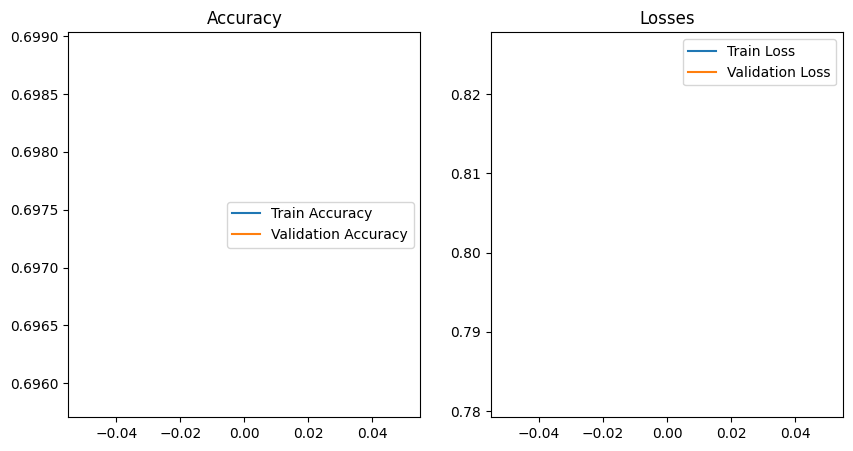

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Left plots
ax[0].plot(train_accs, label='Train Accuracy')
ax[0].plot(val_accs, label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()


ax[1].plot(train_losses, label='Train Loss')
ax[1].plot(val_losses, label='Validation Loss')
ax[1].set_title('Losses')
ax[1].legend()
plt.show()

In [22]:
print("MODEL Trrained now lets predict !")

MODEL Trrained now lets predict !


In [23]:
# Save only the model's state dictionary
torch.save(model.state_dict(), 'my_VGG16_model.pth')
print("Model state dictionary saved successfully after training!")

Model state dictionary saved successfully after training!
